# CLDN16
[Hypomagnesemia-3 (HOMG3)](https://omim.org/entry/248250) is caused by homozygous or compound heterozygous mutation in the claudin-16 gene (CLDN16).

> [Godron A, et al. (2012)](https://pubmed.ncbi.nlm.nih.gov/22422540/) analyzed 32 individuals with CLD16 and CLD19 variants and concluded that
CLDN19 mutations may display more severe renal impairment than patients with CLDN16 mutations.

> [Radonsky V, et al. (2020)](https://pubmed.ncbi.nlm.nih.gov/32710267/) suggest a correlation with large CLDN16 deletions and severe phenotypes but do not provide narrative or statistical evidence.

In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using gpsea version 0.9.6.dev0


### CLDN16
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for CLDN16.

In [2]:
gene_symbol = 'CLDN16'
mane_tx_id = 'NM_006580.4'
mane_protein_id = 'NP_006571.2' # claudin-16


In [4]:
from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.24") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
print(f'Loaded {len(phenopackets)} phenopackets')

from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets
cohort_creator = configure_caching_cohort_creator(hpo)

cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)

validation.summarize()

Loaded 51 phenopackets
Individuals Processed: 100%|██████████| 51/51 [00:02<00:00, 18.23 individuals/s] 
Validated under permissive policy
No errors or warnings were found


In [5]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
51,Nephrocalcinosis
45,Hypercalciuria
35,Hypermagnesiuria
33,Renal insufficiency
30,Elevated circulating parathyroid hormone level
30,Renal magnesium wasting
23,Polyuria
22,Polydipsia
21,Hypomagnesemia
17,Recurrent urinary tract infections


/tmp/ipykernel_20483/1519614747.py:22: DeprecationWarning: draw_protein_diagram was deprecated and will be removed in `1.0.0`. Use `draw_protein` instead
  visualizer.draw_protein_diagram(


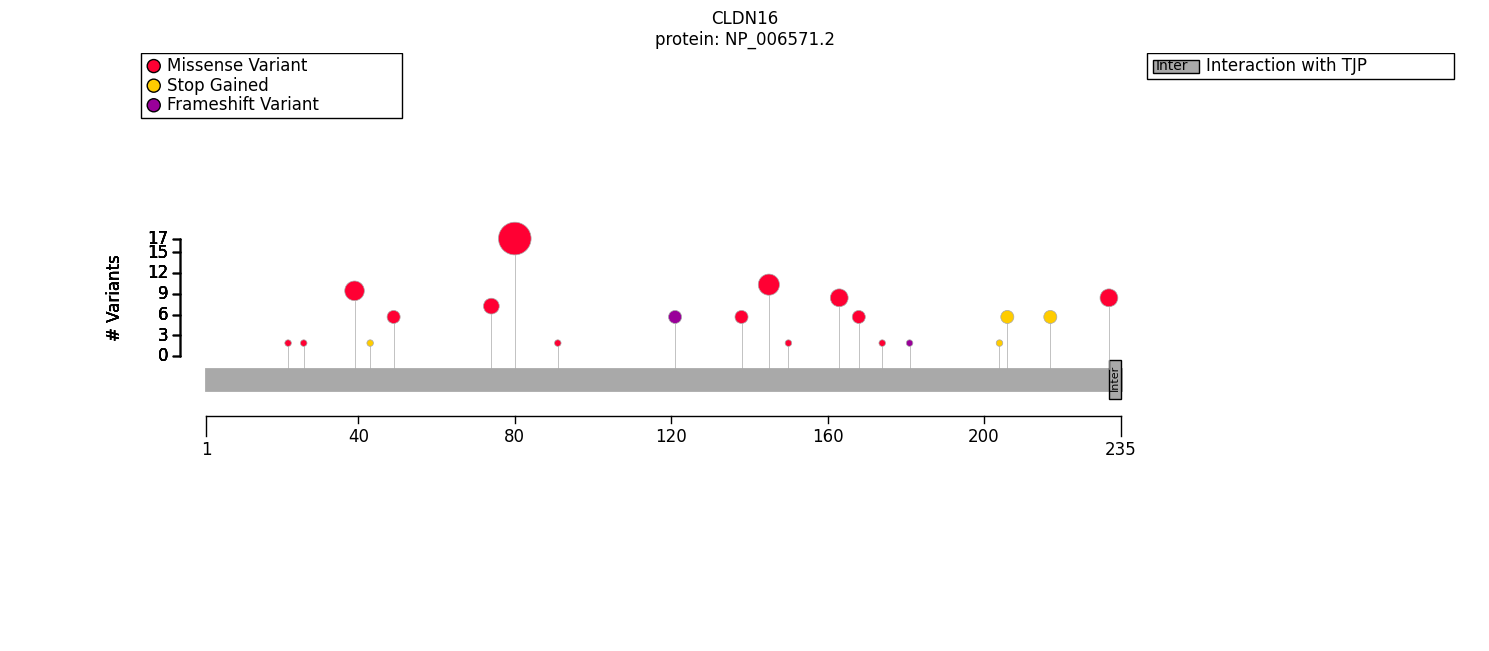

In [6]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)

# Could not use UniProt API, downloaded JSON file manually
protein_meta = ProteinMetadata.from_uniprot_json(
        protein_id=mane_protein_id,
        label="CLDN16",
        uniprot_json="Q9Y5I7.json",
        protein_length=235,
)


cldn16_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
cldn16_fig.tight_layout()

# Genotype-Phenotype Correlation (GPC) Analysis

In [7]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest 
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [8]:
from gpsea.analysis.clf import biallelic_classifier
from gpsea.analysis.predicate import variant_effect
from gpsea.model import VariantEffect
from gpsea.view import summarize_hpo_analysis

is_missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

missense_clf = biallelic_classifier(
    a_predicate=is_missense,
    b_predicate=~is_missense,
    a_label="missense",
    b_label="other",
    partitions = ({0,1}, {2,})
)

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group,missense/missense OR missense/other,other/other,Corrected p values,p values
Stage 5 chronic kidney disease [HP:0003774],2/39 (5%),5/10 (50%),0.052223,0.002271
Nephrolithiasis [HP:0000787],7/30 (23%),2/2 (100%),0.834677,0.072581
Failure to thrive [HP:0001508],7/24 (29%),1/1 (100%),1.000000,0.320000
Abdominal pain [HP:0002027],8/24 (33%),1/1 (100%),1.000000,0.360000
Recurrent urinary tract infections [HP:0000010],14/30 (47%),3/4 (75%),1.000000,0.601173
Abnormal magnesium concentration [HP:0004921],12/12 (100%),9/9 (100%),1.000000,1.000000
Abnormal blood inorganic cation concentration [HP:0010927],12/12 (100%),9/9 (100%),1.000000,1.000000
Hypomagnesemia [HP:0002917],12/13 (92%),9/9 (100%),1.000000,1.000000
Abnormal drinking behavior [HP:0030082],19/19 (100%),3/3 (100%),1.000000,1.000000
Polydipsia [HP:0001959],19/24 (79%),3/3 (100%),1.000000,1.000000


In [9]:
from gpsea.analysis.predicate import variant_key

l81y = variant_key("3_190404787_190404787_G_T") # c.243G>T	p.Leu81Phe	
l81y_clf = biallelic_classifier(
    a_predicate=l81y,
    b_predicate=~l81y,
    a_label="Leu81Phe",
    b_label="other",
     partitions={(0,), (2,1)})
l81y_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=l81y_clf,
    pheno_clfs=pheno_clfs,
)

summarize_hpo_analysis(hpo=hpo, result=l81y_result)

Allele group,Leu81Phe/Leu81Phe,other/other OR Leu81Phe/other,Corrected p values,p values
Hyperuricosuria [HP:0003149],5/13 (38%),9/12 (75%),1.0,0.110701
Failure to thrive [HP:0001508],6/13 (46%),2/12 (17%),1.0,0.201556
Vomiting [HP:0002013],6/13 (46%),2/11 (18%),1.0,0.210796
Sterile pyuria [HP:0100586],9/13 (69%),5/11 (45%),1.0,0.408097
Nephrolithiasis [HP:0000787],5/13 (38%),4/19 (21%),1.0,0.426935
Hypermagnesiuria [HP:0012608],13/13 (100%),22/24 (92%),1.0,0.531532
Hypercalciuria [HP:0002150],13/13 (100%),32/36 (89%),1.0,0.561914
Tetany [HP:0001281],1/13 (8%),2/11 (18%),1.0,0.576087
Polyuria [HP:0000103],10/13 (77%),13/15 (87%),1.0,0.638889
Microscopic hematuria [HP:0002907],4/13 (31%),2/12 (17%),1.0,0.644720


In [10]:
from gpsea.analysis.clf import sex_classifier

mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo, mf_result)

Sex,FEMALE,MALE,Corrected p values,p values
Failure to thrive [HP:0001508],6/10 (60%),2/15 (13%),0.560277,0.028042
Tetany [HP:0001281],3/9 (33%),0/15 (0%),0.560277,0.041502
Abdominal pain [HP:0002027],6/10 (60%),3/15 (20%),0.671209,0.087221
Vomiting [HP:0002013],5/9 (56%),3/15 (20%),0.671209,0.099438
Rickets [HP:0002748],2/9 (22%),0/15 (0%),0.704348,0.130435
Hypomagnesemia [HP:0002917],8/9 (89%),12/12 (100%),1.000000,0.428571
Stage 5 chronic kidney disease [HP:0003774],4/20 (20%),3/28 (11%),1.000000,0.429373
Hypermagnesiuria [HP:0012608],13/13 (100%),21/23 (91%),1.000000,0.525397
Polydipsia [HP:0001959],9/10 (90%),13/17 (76%),1.000000,0.620959
Polyuria [HP:0000103],9/10 (90%),14/18 (78%),1.000000,0.626374


In [11]:
from gpsea.analysis.temporal.endpoint import disease_onset
hypomagnesemia_3 = "OMIM:248250"
hm3_onset = disease_onset(disease_id=hypomagnesemia_3)
from gpsea.analysis.temporal.stats import LogRankTest
survival_statistic = LogRankTest()
from gpsea.analysis.temporal import SurvivalAnalysis
survival_analysis = SurvivalAnalysis(
    statistic=survival_statistic,
)
missense_onset_result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_clf=missense_clf,
    endpoint=hm3_onset,
)
print(f"survival analysis p={missense_onset_result.pval:.5f}")


survival analysis p=0.33269


In [12]:
from gpsea.analysis.temporal.endpoint import hpo_onset
# Stage 5 chronic kidney disease HP:0003774
s5ckd = hpotk.TermId.from_curie("HP:0003774")
s5ckd_endpoint = hpo_onset(hpo=hpo, term_id=s5ckd)
s5ckd_onset_result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_clf=missense_clf,
    endpoint=s5ckd_endpoint,
)
print(f"survival analysis p={s5ckd_onset_result.pval:.5f}")

survival analysis p=0.03415


Text(1000, 0.6, '$p=0.03415$')

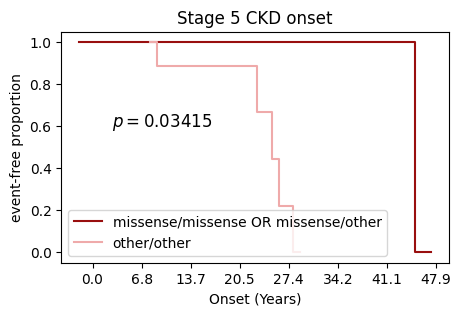

In [13]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

s5ckd_onset_fig, ax = plt.subplots(figsize=(5, 3))
s5ckd_onset_result.plot_kaplan_meier_curves(ax=ax)
def days_to_years(x, pos):
    return f"{x / 365.25:.1f}"


ax.xaxis.set_major_formatter(FuncFormatter(days_to_years))
ax.set_xlabel("Onset (Years)")
ax.set_ylabel("event-free proportion")
ax.set_title("Stage 5 CKD onset")
s = f"p={s5ckd_onset_result.pval:.5f}"
ax.text(x=1000, y=0.6, s=f"${s}$", fontsize=12)

# Summary

In [14]:
from gpseacs.report import  GPAnalysisResultSummary, GpseaAnalysisReport


m_results = (
    GPAnalysisResultSummary.from_mono(
        result=missense_onset_result
    ),
 GPAnalysisResultSummary.from_mono(
        result=s5ckd_onset_result
    ),
)

f_results =  (
    GPAnalysisResultSummary.from_multi(
        result=l81y_result,
    ), 
    GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=mf_result,
    ), 
)

report = GpseaAnalysisReport(
    name=gene_symbol,
    cohort=cohort,
    mono_results=m_results,
    fet_results=f_results,
    gene_symbol=gene_symbol,
    mane_tx_id=mane_tx_id,
    mane_protein_id=mane_protein_id,
)

In [15]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [16]:
summarizer.process_latex(report=report, protein_fig=cldn16_fig, stats_fig=s5ckd_onset_fig)

Figure saved to ../../supplement/img/CLDN16_protein_diagram-draft.pdf
Figure saved to ../../supplement/img/CLDN16_stats-draft.pdf
Output to ../../supplement/tex/CLDN16_summary_draft.tex
